In [1]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import pandas as pd

import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
class Data(Dataset): 
    def __init__(self, root_dir): 
        self.root_dir = root_dir
        self.instances = sorted([
            os.path.join(self.root_dir, file) 
            for file in os.listdir(self.root_dir)
        ])
    
    def __len__(self):
        return len(self.instances)
    
    def __getitem__(self, index):

        img = Image.open(self.instances[index])

        trans_256 = transforms.Compose([transforms.Resize((256,256), 2)])
        trans_32 = transforms.Compose([transforms.Resize((64,64), 2)])

        instance = trans_256(trans_32(img))
        label = trans_256(img)
        
        to_tensor = transforms.Compose([transforms.ToTensor()])
        instance = to_tensor(instance)
        label = to_tensor(label)
        
        instance = self.normalize(instance)
        label = self.normalize(label)
        
        return instance, label
    
    def normalize(self, img):
        return (img - 0.5) * 2
    
    def unnormalize(self, img):
        return img / 2 + 0.5


In [3]:
traindata = Data("DIV2K_train_HR")
validdata = Data("DIV2K_valid_HR")
testdata = Data("DIV2K_valid_HR")
BATCH_SIZE = 64
trainset = DataLoader(traindata, batch_size = BATCH_SIZE, shuffle = True, num_workers = 16)
validset = DataLoader(validdata, batch_size = BATCH_SIZE, shuffle = False, num_workers = 16)
testset = DataLoader(testdata, batch_size = BATCH_SIZE, shuffle = False, num_workers = 16)

In [4]:
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 9, padding = 9 // 2),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size = 5, padding = 5 // 2),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size = 5, padding = 5 // 2),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [5]:
model = SRCNN()

model = model.to(device)
model = nn.DataParallel(model)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
mse_loss = nn.MSELoss()

In [6]:
NUM_EPOCHS = 64

def totalcost(model, data_loader):
    totalcost=0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
        output = model(features)
        totalcost += mse_loss(output,targets)
    return totalcost


start_time = time.time()

traincostlist=[]
validcostlist=[]

for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(trainset):
    
        features = features.to(device)
        targets = targets.to(device)
            
        optimizer.zero_grad()
        
        output = model(features)
        cost = mse_loss(output,targets)
        
        cost.backward()
        
        optimizer.step()
        
        if not batch_idx % 2:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(trainset):03d} |' 
                   f' Cost: {cost:.4f}')

    model.eval()
    with torch.set_grad_enabled(False):
        traincost=totalcost(model,trainset)
        traincostlist.append(traincost)
        validcost=totalcost(model,validset)
        validcostlist.append(validcost)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Cost: {traincost:.2f}%'
              f' | Validation Cost.: {validcost:.2f}%')
        
    elapsed = (time.time() - start_time)
    print(f'Time elapsed: {elapsed:.4f} sec')
  
elapsed = (time.time() - start_time)
print(f'Total Training Time: {elapsed:.4f} sec')

Epoch: 001/064 | Batch 000/013 | Cost: 0.3267
Epoch: 001/064 | Batch 002/013 | Cost: 0.0954
Epoch: 001/064 | Batch 004/013 | Cost: 0.0939
Epoch: 001/064 | Batch 006/013 | Cost: 0.0727
Epoch: 001/064 | Batch 008/013 | Cost: 0.0503
Epoch: 001/064 | Batch 010/013 | Cost: 0.0633
Epoch: 001/064 | Batch 012/013 | Cost: 0.0458
Epoch: 001/064 Train Cost: 0.63% | Validation Cost.: 0.10%
Time elapsed: 36.7311 sec
Epoch: 002/064 | Batch 000/013 | Cost: 0.0486
Epoch: 002/064 | Batch 002/013 | Cost: 0.0466
Epoch: 002/064 | Batch 004/013 | Cost: 0.0412
Epoch: 002/064 | Batch 006/013 | Cost: 0.0403
Epoch: 002/064 | Batch 008/013 | Cost: 0.0411
Epoch: 002/064 | Batch 010/013 | Cost: 0.0388
Epoch: 002/064 | Batch 012/013 | Cost: 0.0395
Epoch: 002/064 Train Cost: 0.47% | Validation Cost.: 0.08%
Time elapsed: 69.1375 sec
Epoch: 003/064 | Batch 000/013 | Cost: 0.0373
Epoch: 003/064 | Batch 002/013 | Cost: 0.0302
Epoch: 003/064 | Batch 004/013 | Cost: 0.0318
Epoch: 003/064 | Batch 006/013 | Cost: 0.0308
Ep

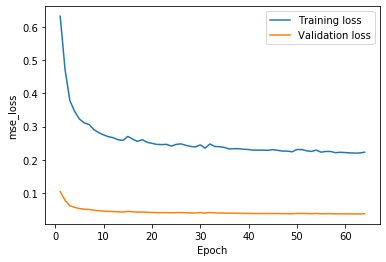

In [7]:
plt.plot(range(1, NUM_EPOCHS+1), traincostlist, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), validcostlist, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('mse_loss')
plt.xlabel('Epoch')
plt.show()

In [8]:
model.eval()
testcost = totalcost(model, testset)
print(f'Test cost: {testcost:.4f}')

Test cost: 0.0375


In [9]:
torch.save(model, 'srcnnmodel')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DataParallel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SRCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.

In [10]:
print(model)

DataParallel(
  (module): SRCNN(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): ReLU()
      (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
      (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): Tanh()
    )
  )
)


In [11]:
instance, label = validdata[0]
output = model(instance[None, :, :, :])
output = output[0]

In [12]:
instance_img = validdata.unnormalize(instance.cpu())
label_img = validdata.unnormalize(label.cpu())
output_img = validdata.unnormalize(output.cpu())

instance_img = transforms.ToPILImage()(instance_img).convert('RGB')
label_img = transforms.ToPILImage()(label_img).convert('RGB')
output_img = transforms.ToPILImage()(output_img).convert('RGB')

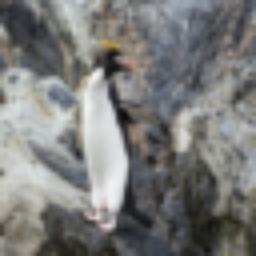

In [13]:
instance_img

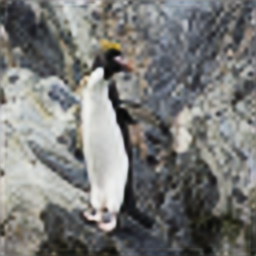

In [14]:
output_img

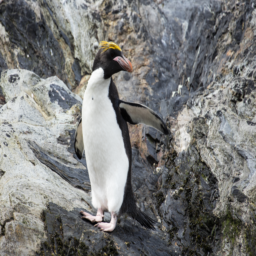

In [15]:
label_img

In [21]:
instance, label = traindata[2]
output = model(instance[None, :, :, :])
output = output[0]

In [22]:
instance_img = validdata.unnormalize(instance.cpu())
label_img = validdata.unnormalize(label.cpu())
output_img = validdata.unnormalize(output.cpu())

instance_img = transforms.ToPILImage()(instance_img).convert('RGB')
label_img = transforms.ToPILImage()(label_img).convert('RGB')
output_img = transforms.ToPILImage()(output_img).convert('RGB')

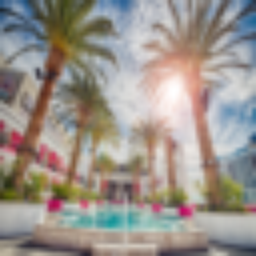

In [23]:
instance_img

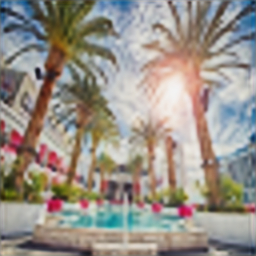

In [24]:
output_img

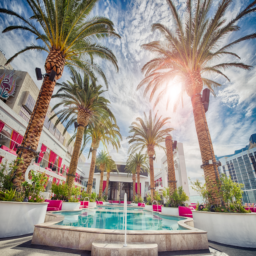

In [25]:
label_img